In [1]:
import sqlite3
import pandas as pd
import numpy as np
import time
import pickle
import pyarrow.parquet as pq
import pyarrow as pa
import _pickle as cPickle
import feather
import os

In [2]:
# Load the csv for current processing
# File size is 469MB

csvfile = 'hydraulic_systems_demo_data.csv'
df = pd.read_csv(csvfile)

In [3]:
# Time to read csv from pandas

def calculate_read_csv_time(csvfile):
    start = time.time()
    df = pd.read_csv(csvfile)
    csvreadtime = time.time()-start
    return csvreadtime

In [4]:
# Time to read csv from pandas in chunks
# Time to read csv in chunks is more than without chunks always

def calculate_read_csv_in_chunks_time(csvfile,csize):
    start = time.time()
    tempDF = pd.read_csv(csvfile,nrows=1)
    
    cols = tempDF.columns.values.tolist()
    newDF = pd.DataFrame(columns=cols)
    for chunk in pd.read_csv(csvfile,chunksize=csize):
        newDF = pd.concat([newDF,chunk])
    csvchunkreadtime = time.time()-start
    return csvchunkreadtime

In [5]:
# Time to read multiple csvs
# The file size is around 140MB,140MB,140MB,35MB,35MB

csvfiles = ['folder/hydraulic1.csv','folder/hydraulic2.csv','folder/hydraulic3.csv','folder/hydraulic4.csv','folder/hydraulic5.csv']

def calculate_multiple_csv_read_time(csvfiles):
    start = time.time()
    tempDF = pd.read_csv(csvfiles[0],nrows=1)
    
    cols = tempDF.columns.values.tolist()
    newdf = pd.DataFrame(columns=cols)
    for csvfile in csvfiles:
        localdf = pd.read_csv(csvfile)
        newdf = pd.concat([newdf,localdf])
    multiplecsvreadtime = time.time()-start
    return multiplecsvreadtime

In [6]:
# Saving in the sqlite db

sqlfile = 'hydraulic.sqlite3'

def calculate_df_to_sql_save_time(csvfile,sqlfile,nameoftable):
    sqlconnection = sqlite3.connect(sqlfile)
    start = time.time()
#   iteration=0
    sqlquery = "DELETE FROM %s" % nameoftable
    sqlcursor = sqlconnection.cursor()
    sqlcursor.execute(sqlquery)
    sqlcursor.fetchall()
    for chunk in pd.read_csv(csvfile,chunksize=1000):
        chunk.to_sql(name=nameoftable,con=sqlconnection,if_exists="append",index=False)
    sqlsavetime = time.time()-start
    return sqlsavetime

In [7]:
# Time to query in the sqlite db
# We are querying for the row where the timestamp is '2020-12-11 03:31:30'

def calculate_sql_query_time(sqlfile,nameoftable):
    sqlstatement = "SELECT * FROM %s WHERE timestamp IS '2020-12-11 03:31:30'" % nameoftable
    start = time.time()
    sqlconnection = sqlite3.connect(sqlfile)
    sqlcursor = sqlconnection.cursor()
    sqlcursor.execute(sqlstatement)
    sqlcursor.fetchall()
    sqlquerytime = time.time()-start
    return sqlquerytime

In [8]:
# Time to read the sql db

dfsql = None

def calculate_sql_to_df_load_time(sqlfile,dfsql,nameoftable):
    query = "SELECT * FROM %s" % (nameoftable)
    start = time.time()
    sqlconnection = sqlite3.connect(sqlfile)
    dfsql = pd.read_sql_query(query,sqlconnection)
    sqlreadtime = time.time()-start
    return sqlreadtime

In [9]:
# Time to save the pickle file

picklfile = "hydraulic.pkl"

def calculate_df_to_pickle_time(picklfile,df):
    start = time.time()
    with open(picklfile,"wb") as f:
        pickle.dump(df,f)
    picklesavetime = time.time()-start
    return picklesavetime

In [10]:
# Time to load the pickle file content as dataframe in pandas

dfpkl = None

def calculate_pickl_to_df_load_time(picklfile,dfpkl):
    start = time.time()
    with open(picklfile,"rb") as f:
        dfpkl = pickle.load(f)
    picklereadtime = time.time()-start
    return picklereadtime

In [11]:
# Time to save the dataframe as a parquet file
# Approach 1 - without using pytables

parquet_file1 = 'df.parquet.gzip'
compression_type = 'gzip'

def calculate_df_to_parquet_save_time_approach1(parquet_file,compression_type,df):
    start = time.time()
    df.to_parquet(parquet_file,compression=compression_type)
    parquetsavetime = time.time()-start
    return parquetsavetime

In [12]:
# Time to read the parquet file to the dataframe
# Approach 1

dfparquet1 = None

def calculate_parquet_to_df_load_time_approach1(parquet_file,dfparquet):
    start = time.time()
    dfparquet = pd.read_parquet(parquet_file)
    parquetloadtime = time.time()-start
    return parquetloadtime

In [13]:
# Time to save the parquet file to the dataframe
# Approach 2 - using pytables

parquet_file2 = 'df.parquet'

def calculate_df_to_parquet_save_time_approach2(parquet_file,df):
    start = time.time()
    table = pa.Table.from_pandas(df)
    pq.write_table(table,parquet_file)
    parquetsavetime = time.time()-start
    return parquetsavetime

In [14]:
# Time to read the parquet file to the dataframe
# Approach 2 - using pytables

dfparquet2 = None

def calculate_parquet_to_df_load_time_approach2(parquet_file,dfparquet):
    start = time.time()
    table = pq.read_table(parquet_file)
    dfparquet = table.to_pandas()
    parquetloadtime = time.time()-start
    return parquetloadtime

In [15]:
# Time to save cPickle file

cpklfile = 'hydraulicc.pkl'

def calculate_df_to_cpkl_save_time(cpklfile,df):
    start = time.time()
    with open(cpklfile,"wb") as f:
        cPickle.dump(df,f)
    cpicklesavetime = (time.time()-start)
    return cpicklesavetime

In [16]:
# Time to load cPickle file

dfcpkl = None

def calculate_cpkl_to_df_load_time(cpklfile,dfcpkl):
    start = time.time()
    with open(cpklfile,"rb") as f:
        dfcpkl = cPickle.load(f)
    cpickleloadtime = time.time()-start
    return cpickleloadtime

In [17]:
# Time to save dataframe as feather

featherfile = 'hydraulic.feather'

def calculate_df_to_feather_save_time(featherfile,df):
    start = time.time()
    feather.write_dataframe(df,featherfile)
    feathersavetime = time.time()-start
    return feathersavetime

In [18]:
# Time to read the feather file

dffeather = None

def calculate_feather_to_df_load_time(featherfile,dffeather):
    start = time.time()
    dffeather = feather.read_dataframe(featherfile)
    featherloadtime = time.time()-start
    return featherloadtime

In [19]:
# Time to query the dataframe
# Say we are quering to find the row with timestamp 2020-12-11 03:31:30

def calculate_time_to_query_df(df):
    start = time.time()
    df.loc[df['timestamp'] == "2020-12-11 03:31:30"]
    dfquerytime = time.time()-start
    return dfquerytime

In [20]:
n = 25
read_csv_times = []
read_multiple_csv_times = []
read_csv_chunks_times = []
df_to_sql_times = []
query_sql_times = []
sql_to_df_times = []
df_to_pkl_times = []
pkl_to_df_times = []
df_to_parquet_app1_times = []
parquet_to_df_app1_times = []
df_to_parquet_app2_times = []
parquet_to_df_app2_times = []
df_to_cpkl_times = []
cpkl_to_df_times = []
df_to_feather_times = []
feather_to_df_times = []
query_df_times = []

In [22]:
# Calculating average time calculations

for i in range(0,n):
    read_csv_time = calculate_read_csv_time(csvfile)
    read_csv_times.append(read_csv_time)
    
    print("CSV read times: %d - value: %f" % (i+1, read_csv_time))
    
    read_csv_chunks_time = calculate_read_csv_in_chunks_time(csvfile,1000000)
    read_csv_chunks_times.append(read_csv_chunks_time)
    
    print("CSV read times in chunks times: %d - value: %f" % (i+1,read_csv_chunks_time))
    
    read_multiple_csv_time = calculate_multiple_csv_read_time(csvfiles)
    read_multiple_csv_times.append(read_multiple_csv_time)
    
    print("Multiple CSV read times: %d - value: %f" % (i+1,read_multiple_csv_time))
    
    df_to_sql_time = calculate_df_to_sql_save_time(csvfile,sqlfile,'content')
    df_to_sql_times.append(df_to_sql_time)
    
    print("DF to SQL times: %d - value: %f" % (i+1,df_to_sql_time))
    
    query_sql_time = calculate_sql_query_time(sqlfile,'content')
    query_sql_times.append(query_sql_time)
    
    print("SQL Query times: %d - value: %f" % (i+1,query_sql_time))
    
    sql_to_df_time = calculate_sql_to_df_load_time(sqlfile,dfsql,'content')
    sql_to_df_times.append(sql_to_df_time)
    
    print("SQL to DF times: %d - value: %f" % (i+1,sql_to_df_time))
    
    df_to_pkl_time = calculate_df_to_pickle_time(picklfile,df)
    df_to_pkl_times.append(df_to_pkl_time)
    
    print("DF to Pickle times: %d - value: %f" % (i+1,df_to_pkl_time))
    
    pkl_to_df_time = calculate_pickl_to_df_load_time(picklfile,dfpkl)
    pkl_to_df_times.append(pkl_to_df_time)
    
    print("Pickle to DF times: %d - value: %f" % (i+1,pkl_to_df_time))
    
    df_to_parquet_app1_time = calculate_df_to_parquet_save_time_approach1(parquet_file1,compression_type,df)
    df_to_parquet_app1_times.append(df_to_parquet_app1_time)
    
    print("DF to Parquet approach 1 times: %d - value: %f" % (i+1,df_to_parquet_app1_time))
    
    parquet_to_df_app1_time = calculate_parquet_to_df_load_time_approach1(parquet_file1,dfparquet1)
    parquet_to_df_app1_times.append(parquet_to_df_app1_time)
    
    print("Parquet to DF approach 1 times: %d - value: %f" % (i+1,parquet_to_df_app1_time))
    
    df_to_parquet_app2_time = calculate_df_to_parquet_save_time_approach2(parquet_file2,df)
    df_to_parquet_app2_times.append(df_to_parquet_app2_time)
    
    print("DF to Parquet approach 2 times: %d - value: %f" % (i+1,df_to_parquet_app2_time))
    
    parquet_to_df_app2_time = calculate_parquet_to_df_load_time_approach2(parquet_file2,dfparquet2)
    parquet_to_df_app2_times.append(parquet_to_df_app2_time)
    
    print("Parquet to DF approach 2 times: %d - value: %f" % (i+1,parquet_to_df_app2_time))
    
    df_to_cpkl_time = calculate_df_to_cpkl_save_time(cpklfile,df)
    df_to_cpkl_times.append(df_to_cpkl_time)
    
    print("DF to cPickle times: %d - value: %f" % (i+1,df_to_cpkl_time))
    
    cpkl_to_df_time = calculate_cpkl_to_df_load_time(cpklfile,dfcpkl)
    cpkl_to_df_times.append(cpkl_to_df_time)
    
    print("cPickle to DF times: %d - value: %f" % (i+1,cpkl_to_df_time))
    
    df_to_feather_time = calculate_df_to_feather_save_time(featherfile,df)
    df_to_feather_times.append(df_to_feather_time)
    
    print("DF to feather times: %d - value: %f" % (i+1,df_to_feather_time))
    
    feather_to_df_time = calculate_feather_to_df_load_time(featherfile,dffeather)
    feather_to_df_times.append(feather_to_df_time)
    
    print("Feather to DF times: %d - value: %f" % (i+1,feather_to_df_time))
    
    query_df_time = calculate_time_to_query_df(df)
    query_df_times.append(query_df_time)
    
    print("Query DF times: %d - value: %f" % (i+1,query_df_time))

CSV read times: 1 - value: 13.167512
CSV read times in chunks times: 1 - value: 14.758459
Multiple CSV read times: 1 - value: 16.596648
DF to SQL times: 1 - value: 63.734739
SQL Query times: 1 - value: 0.619538
SQL to DF times: 1 - value: 28.584941
DF to Pickle times: 1 - value: 2.715014
Pickle to DF times: 1 - value: 1.325665
DF to Parquet approach 1 times: 1 - value: 8.513625
Parquet to DF approach 1 times: 1 - value: 0.981755
DF to Parquet approach 2 times: 1 - value: 3.699078
Parquet to DF approach 2 times: 1 - value: 0.959558
DF to cPickle times: 1 - value: 3.254588
cPickle to DF times: 1 - value: 1.332847
DF to feather times: 1 - value: 1.595392
Feather to DF times: 1 - value: 0.477990
Query DF times: 1 - value: 0.308191
CSV read times: 2 - value: 13.160103
CSV read times in chunks times: 2 - value: 14.687700
Multiple CSV read times: 2 - value: 17.144060
DF to SQL times: 2 - value: 73.055569
SQL Query times: 2 - value: 0.632129
SQL to DF times: 2 - value: 28.943994
DF to Pickle t

Multiple CSV read times: 12 - value: 18.210517
DF to SQL times: 12 - value: 68.288910
SQL Query times: 12 - value: 0.693405
SQL to DF times: 12 - value: 30.112884
DF to Pickle times: 12 - value: 3.982553
Pickle to DF times: 12 - value: 1.382362
DF to Parquet approach 1 times: 12 - value: 9.210316
Parquet to DF approach 1 times: 12 - value: 1.008671
DF to Parquet approach 2 times: 12 - value: 3.872856
Parquet to DF approach 2 times: 12 - value: 0.976646
DF to cPickle times: 12 - value: 4.994362
cPickle to DF times: 12 - value: 1.415143
DF to feather times: 12 - value: 13.100887
Feather to DF times: 12 - value: 0.521293
Query DF times: 12 - value: 0.331000
CSV read times: 13 - value: 14.251940
CSV read times in chunks times: 13 - value: 15.864710
Multiple CSV read times: 13 - value: 18.174257
DF to SQL times: 13 - value: 68.296900
SQL Query times: 13 - value: 0.671719
SQL to DF times: 13 - value: 30.343112
DF to Pickle times: 13 - value: 3.385057
Pickle to DF times: 13 - value: 1.396618


CSV read times: 23 - value: 14.531787
CSV read times in chunks times: 23 - value: 16.224348
Multiple CSV read times: 23 - value: 18.068259
DF to SQL times: 23 - value: 69.268489
SQL Query times: 23 - value: 0.653117
SQL to DF times: 23 - value: 31.708381
DF to Pickle times: 23 - value: 3.706298
Pickle to DF times: 23 - value: 2.860542
DF to Parquet approach 1 times: 23 - value: 11.593372
Parquet to DF approach 1 times: 23 - value: 1.269550
DF to Parquet approach 2 times: 23 - value: 4.113946
Parquet to DF approach 2 times: 23 - value: 1.389994
DF to cPickle times: 23 - value: 5.392151
cPickle to DF times: 23 - value: 1.477421
DF to feather times: 23 - value: 6.004313
Feather to DF times: 23 - value: 0.560929
Query DF times: 23 - value: 0.325901
CSV read times: 24 - value: 14.790836
CSV read times in chunks times: 24 - value: 16.328423
Multiple CSV read times: 24 - value: 18.711980
DF to SQL times: 24 - value: 77.743264
SQL Query times: 24 - value: 0.691617
SQL to DF times: 24 - value: 

In [38]:
def calcavg(lst):
    total = 0
    for val in lst:
        total = total + val
    return total/len(lst)

def getmax(lst):
    mx=0
    for val in lst:
        if mx<val:
            mx=val
    return mx

def getmn(lst):
    mn=1000000
    for val in lst:
        if mn>val:
            mn=val
    return mn

In [44]:
print("The times are as follows:")
readcsvdetails = """Using pandas pd.read_csv:
Average read time : %f
Maximum read time : %f
Minimum read time : %f
""" % (calcavg(read_csv_times),getmax(read_csv_times),getmn(read_csv_times))
print(readcsvdetails)

print("Reading csv in chunks")
readcsvinchunks = """
Average read time : %f
Maximum read time : %f
Minimum read time : %f
""" % (calcavg(read_csv_chunks_times),getmax(read_csv_chunks_times),getmn(read_csv_chunks_times))
print(readcsvinchunks)

print("Reading multiple csvs")
readmultiplecsvs = """
Average read time : %f
Maximum read time : %f
Minimum read time : %f
""" % (calcavg(read_multiple_csv_times),getmax(read_multiple_csv_times),getmn(read_multiple_csv_times))
print(readmultiplecsvs)

print("DF to SQL")
dftosql = """
Average convert time : %f
Maximum convert time : %f
Minimum convert time : %f
""" % (calcavg(df_to_sql_times),getmax(df_to_sql_times),getmn(df_to_sql_times))
print(dftosql)

print("SQL Query")
querysql = """
Average query time : %f
Maximum query time : %f
Minimum query time : %f
""" % (calcavg(query_sql_times),getmax(query_sql_times),getmn(query_sql_times))
print(querysql)

print("SQL to DF")
sqltodf = """
Average df convert time : %f
Maximum df convert time : %f
Minimum df convert time : %f
""" % (calcavg(sql_to_df_times),getmax(sql_to_df_times),getmn(sql_to_df_times))
print(sqltodf)

print("DF to Pickle")
dftopkl = """
Average convert time : %f
Maximum convert time : %f
Minimum convert time : %f
""" % (calcavg(df_to_pkl_times),getmax(df_to_pkl_times),getmn(df_to_pkl_times))
print(dftopkl)

print("Pickle to DF")
pkltodf = """
Average df convert time : %f
Maximum df convert time : %f
Minimum df convert time : %f
""" % (calcavg(pkl_to_df_times),getmax(pkl_to_df_times),getmn(pkl_to_df_times))
print(pkltodf)

print("DF to Parquet Approach 1")
dftoparquetapp1 = """
Average convert time : %f
Maximum convert time : %f
Minimum convert time : %f
""" % (calcavg(df_to_parquet_app1_times),getmax(df_to_parquet_app1_times),getmn(df_to_parquet_app1_times))
print(dftoparquetapp1)

print("Parquet to DF Approach 1")
parquettodfapp1 = """
Average df convert time : %f
Maximum df convert time : %f
Minimum df convert time : %f
""" % (calcavg(parquet_to_df_app1_times),getmax(parquet_to_df_app1_times),getmn(parquet_to_df_app1_times))
print(parquettodfapp1)

print("DF to Parquet Approach 2")
dftoparquetapp2 = """
Average convert time : %f
Maximum convert time : %f
Minimum convert time : %f
""" % (calcavg(df_to_parquet_app2_times),getmax(df_to_parquet_app2_times),getmn(df_to_parquet_app2_times))
print(dftoparquetapp2)

print("Parquet to DF Approach 2")
parquettodfapp2 = """
Average df convert time : %f
Maximum df convert time : %f
Minimum df convert time : %f
""" % (calcavg(parquet_to_df_app2_times),getmax(parquet_to_df_app2_times),getmn(parquet_to_df_app2_times))
print(parquettodfapp2)

print("DF to cPickle")
dftocpkl = """
Average convert time : %f
Maximum convert time : %f
Minimum convert time : %f
""" % (calcavg(df_to_cpkl_times),getmax(df_to_cpkl_times),getmn(df_to_cpkl_times))
print(dftocpkl)

print("cPickle to DF")
cpkltodf = """
Average df convert time : %f
Maximum df convert time : %f
Minimum df convert time : %f
""" % (calcavg(cpkl_to_df_times),getmax(cpkl_to_df_times),getmn(cpkl_to_df_times))
print(cpkltodf)

print("DF to Feather")
dftofeather = """
Average convert time : %f
Maximum convert time : %f
Minimum convert time : %f
""" % (calcavg(df_to_feather_times),getmax(df_to_feather_times),getmn(df_to_feather_times))
print(dftofeather)

print("Feather to DF")
feathertodf = """
Average df convert time : %f
Maximum df convert time : %f
Minimum df convert time : %f
""" % (calcavg(feather_to_df_times),getmax(feather_to_df_times),getmn(feather_to_df_times))
print(feathertodf)

print("Query DF")
querydf = """
Average query time : %f
Maximum query time : %f
Minimum query time : %f
""" % (calcavg(query_df_times),getmax(query_df_times),getmn(query_df_times))
print(querydf)

The times are as follows:
Using pandas pd.read_csv:
Average read time : 14.077680
Maximum read time : 14.790836
Minimum read time : 13.160103

Reading csv in chunks

Average read time : 15.557440
Maximum read time : 16.328423
Minimum read time : 14.687700

Reading multiple csvs

Average read time : 17.877719
Maximum read time : 18.711980
Minimum read time : 16.596648

DF to SQL

Average convert time : 68.394861
Maximum convert time : 77.743264
Minimum convert time : 63.734739

SQL Query

Average query time : 0.664032
Maximum query time : 0.693405
Minimum query time : 0.619538

SQL to DF

Average df convert time : 30.119979
Maximum df convert time : 32.022601
Minimum df convert time : 28.127465

DF to Pickle

Average convert time : 3.962858
Maximum convert time : 5.313657
Minimum convert time : 2.695928

Pickle to DF

Average df convert time : 1.438983
Maximum df convert time : 2.860542
Minimum df convert time : 1.321126

DF to Parquet Approach 1

Average convert time : 9.160012
Maximum

In [23]:
import matplotlib.pyplot as plt

In [32]:
xaxis = []
xunits = n
for i in range(0,xunits):
    xaxis.append(i+1)

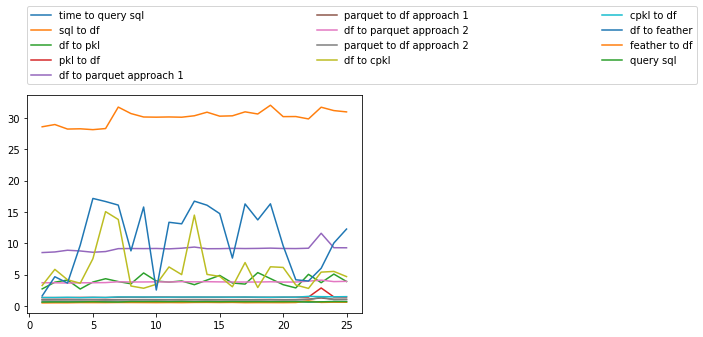

In [36]:
# Plotting the results

plt.plot(xaxis,query_sql_times,label='time to query sql')
plt.plot(xaxis,sql_to_df_times,label='sql to df')
plt.plot(xaxis,df_to_pkl_times,label='df to pkl')
plt.plot(xaxis,pkl_to_df_times,label='pkl to df')
plt.plot(xaxis,df_to_parquet_app1_times,label='df to parquet approach 1')
plt.plot(xaxis,parquet_to_df_app1_times,label='parquet to df approach 1')
plt.plot(xaxis,df_to_parquet_app2_times,label='df to parquet approach 2')
plt.plot(xaxis,parquet_to_df_app2_times,label='parquet to df approach 2')
plt.plot(xaxis,df_to_cpkl_times,label='df to cpkl')
plt.plot(xaxis,cpkl_to_df_times,label='cpkl to df')
plt.plot(xaxis,df_to_feather_times,label='df to feather')
plt.plot(xaxis,feather_to_df_times,label='feather to df')
plt.plot(xaxis,query_sql_times,label='query sql')
plt.legend(bbox_to_anchor=(0., 1.05, 2., .05),
           ncol=3, mode="expand", borderaxespad=0.)

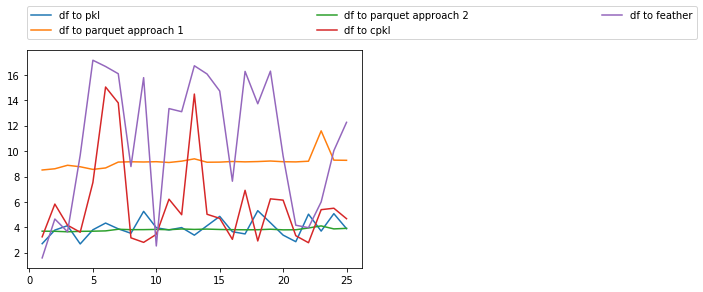

In [46]:
# Plotting the results for df to other format excluding sqlite

plt.plot(xaxis,df_to_pkl_times,label='df to pkl')
plt.plot(xaxis,df_to_parquet_app1_times,label='df to parquet approach 1')
plt.plot(xaxis,df_to_parquet_app2_times,label='df to parquet approach 2')
plt.plot(xaxis,df_to_cpkl_times,label='df to cpkl')
plt.plot(xaxis,df_to_feather_times,label='df to feather')
plt.legend(bbox_to_anchor=(0., 1.05, 2., .05),
           ncol=3, mode="expand", borderaxespad=0.)

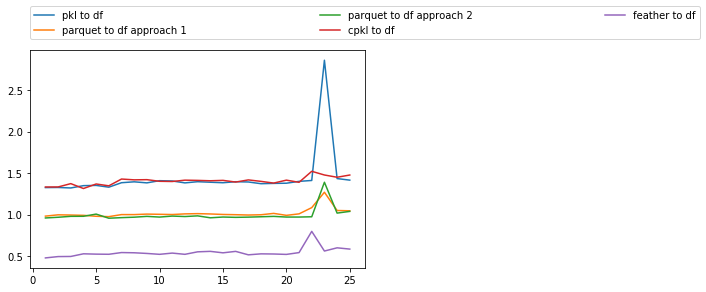

In [47]:
# Plotting the results for other formats to df

plt.plot(xaxis,pkl_to_df_times,label='pkl to df')
plt.plot(xaxis,parquet_to_df_app1_times,label='parquet to df approach 1')
plt.plot(xaxis,parquet_to_df_app2_times,label='parquet to df approach 2')
plt.plot(xaxis,cpkl_to_df_times,label='cpkl to df')
plt.plot(xaxis,feather_to_df_times,label='feather to df')
plt.legend(bbox_to_anchor=(0., 1.05, 2., .05),
           ncol=3, mode="expand", borderaxespad=0.)